In [2]:
# import necessary libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



### Synthetic Dataset Generation 


In [3]:
np.random.seed(42)

n_samples = 2000

floor_area = np.random.uniform(30, 200, n_samples)          # m²
num_rooms = np.random.randint(1, 7, n_samples)
building_type = np.random.choice(["apartment", "independent"], n_samples)
climate_zone = np.random.choice(["hot", "moderate", "cool"], n_samples)

elec_kwh = np.random.uniform(50, 600, n_samples)            # monthly kWh
lpg_kg = np.random.uniform(0, 40, n_samples)                # monthly kg
ac_hours = np.random.uniform(0, 8, n_samples)               # avg hours/day
occupants = np.random.randint(1, 7, n_samples)

# simple synthetic CO2 model (kg/month)
co2_kg = (
    elec_kwh * 0.82 +          # grid factor
    lpg_kg * 2.95 +            # LPG factor
    floor_area * 0.3 +
    ac_hours * 5.0 +
    occupants * 10.0 +
    np.random.normal(0, 50, n_samples)  # noise
)

df = pd.DataFrame({
    "floor_area": floor_area,
    "num_rooms": num_rooms,
    "building_type": building_type,
    "climate_zone": climate_zone,
    "elec_kwh": elec_kwh,
    "lpg_kg": lpg_kg,
    "ac_hours": ac_hours,
    "occupants": occupants,
    "co2_kg": co2_kg
})

df.head()


,floor_area,num_rooms,building_type,climate_zone,elec_kwh,lpg_kg,ac_hours,occupants,co2_kg
0,93.671820,4,apartment,hot,468.019196,27.624910,5.932824,2,624.128579
1,191.621432,3,apartment,hot,76.821475,20.537380,3.091547,6,230.531337
2,154.438970,4,independent,cool,514.050836,26.024261,2.642353,5,541.214224
3,131.771942,6,apartment,moderate,290.924242,35.587497,4.762846,2,458.457735
4,56.523169,2,independent,moderate,238.317318,17.617383,6.977636,2,359.190015


###  Training and comparing models

In [4]:
target = "co2_kg"
X = df.drop(columns=[target])
y = df[target]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "XGBRegressor": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
    ),
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    results.append((name, mae, rmse, r2))

results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"])
results_df


C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Model,MAE,RMSE,R2
0,LinearRegression,40.683872,49.834711,0.879601
1,RandomForest,42.848687,52.932668,0.864166
2,XGBRegressor,43.207138,52.699578,0.865360


### Pick best model and plot Predicted vs Actual

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rebuild best model pipeline (LinearRegression here)
best_model = LinearRegression()

best_pipe = Pipeline(steps=[("preprocess", preprocess),
                            ("model", best_model)])
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae, rmse, r2

C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(40.68387175090714),
 np.float64(49.834710689640076),
 0.8796005719211626)

#### Plot

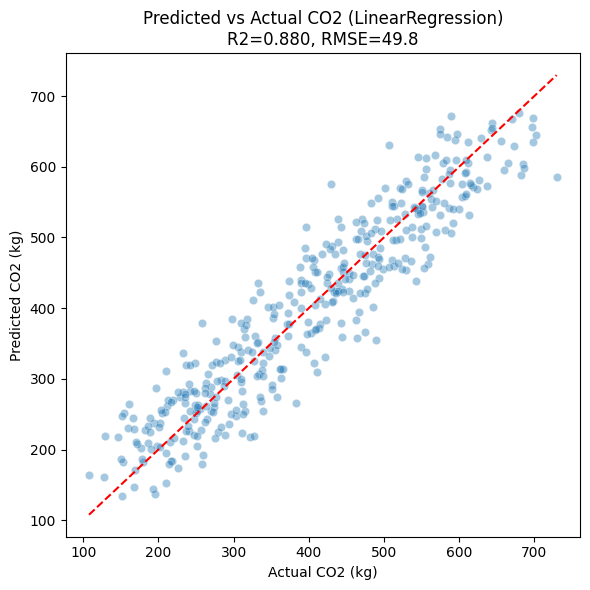

In [6]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.xlabel("Actual CO2 (kg)")
plt.ylabel("Predicted CO2 (kg)")
plt.title(f"Predicted vs Actual CO2 (LinearRegression)\nR2={r2:.3f}, RMSE={rmse:.1f}")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.tight_layout()
plt.show()

### Feature importance (RandomForest & XGBoost)

In [7]:
rf = RandomForestRegressor(n_estimators=300, random_state=42)

rf_pipe = Pipeline(steps=[("preprocess", preprocess),
                          ("model", rf)])
rf_pipe.fit(X_train, y_train)

# Get feature names after preprocessing
ohe = rf_pipe.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

importances = rf_pipe.named_steps["model"].feature_importances_
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp.head(10)

,feature,importance
1,elec_kwh,0.837158
2,lpg_kg,0.078848
0,floor_area,0.037954
3,ac_hours,0.032457
7,climate_zone_hot,0.003216
6,climate_zone_cool,0.003068
8,climate_zone_moderate,0.002985
4,building_type_apartment,0.002193
5,building_type_independent,0.002121


### Plotting Graph

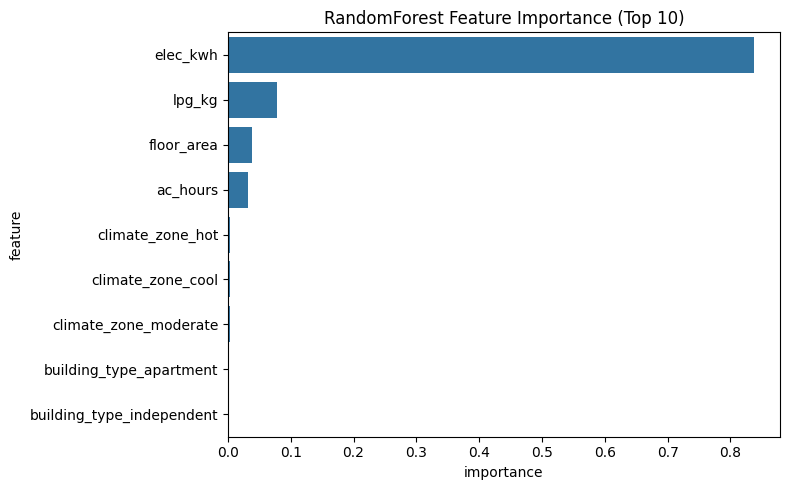

In [8]:
plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp.head(10),
            x="importance", y="feature", orient="h")
plt.title("RandomForest Feature Importance (Top 10)")
plt.tight_layout()
plt.show()


### Save the best pipeline for later deployment

In [9]:
import joblib

joblib.dump(rf_pipe, "sdg13_rf_pipeline.pkl")

['sdg13_rf_pipeline.pkl']

In [10]:
import joblib

joblib.dump(rf_pipe, "sdg13_rf_pipeline.pkl")

['sdg13_rf_pipeline.pkl']